In [36]:
import pandas as pd
from collections import Counter
import numpy as np
import copy
from operator import itemgetter
%matplotlib inline
#from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

Student: Gerardo Caracas Uribe
A-3

In [1]:
import client
from client.api.notebook import Notebook
ok = Notebook('a3.ok')
ok.auth(inline=True, force=True)

Assignment: A3 HMM
OK, version v1.13.11


Open the following URL:

https://okpy.org/client/login/

After logging in, copy the code from the web page and paste it into the box.
Then press the "Enter" key on your keyboard.

Paste your code here: yaz1G7QkUD8QTMbkaqQrtQC1p07lNk
Successfully logged in as gerardocaracasur@u.boisestate.edu


In [2]:
ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'A3-hmm.ipynb'.
Submit... 100% complete
Submission successful for user: gerardocaracasur@u.boisestate.edu
URL: https://okpy.org/boisestate/cs4-533/sp19/a3/submissions/XL648V



# 1.- Read input data #

### 1.1 Read raw data from files ###

In [2]:
train_data = pd.read_csv('train.txt', delimiter=' ', names=['word', 'pos', 'other'])
test_data = pd.read_csv('test.txt', delimiter=' ', names=['word', 'pos', 'other'])

### 1.2 Data cleanup ###

In [3]:
train_data['word'] = train_data.word.str.lower()
test_data['word'] = test_data.word.str.lower()
train_data['ppos'] = train_data.pos.shift(1)
train_data['ppos'] = train_data.ppos.fillna('O')
train_data = train_data.drop(['other'], axis=1)
test_data = test_data.drop(['other'], axis=1)

# 2.- Generate list of sentences #
We will decode with either Greedy or Viterbi each sentence at a time
thus we will generate a list of sentences to be used to decode/evaluate

### 2.1 Define function that splits sentences ###

In [4]:
sentences=[]
finalPos=0
initialPos=0
# splitSentences will be called via an apply function
# that will generate a table of sentences.
def splitSentences(x):
    global initialPos, finalPos, test_data, sentences
    if x.pos == '.':
        sentences.append(test_data[initialPos:finalPos])
        initialPos=(finalPos+1)
    finalPos=finalPos+1

### 2.2 Let's execute an apply operation to split sentences ###

In [5]:
test_data.apply(lambda x: splitSentences(x), axis=1)
print("Number of sentences = {}".format(len(sentences)))

Number of sentences = 1975


### 2.3 Generate list of tags ###

In [6]:
tagsList = list(set(test_data.pos))

# 3.- Probability Functions #

### 3.1 .- Train our probability functions ###

##### We will train our probability functions by using the train set. These functions will be used latter, but with test data.#####

.

In [7]:
smooth = 0.0000001
tags_dict = {}
for col_name in list(set(train_data.pos)):
    tags = train_data[train_data.pos == col_name]
    tags_dict[col_name]=Counter([ row for row in tags.word])

##### Emission Probability Function #####

In [8]:
def PW_T(W='', T=''):
    part = tags_dict[T]
    # smoothing
    if W not in part: return smooth
    return part[W] / sum(part.values())

##### Transition Probability Function #####

In [9]:
pos_ppos = {}
pos_ppos_denom = {}
for col_name in set(train_data.ppos):
    sub_frame = train_data[train_data.ppos == col_name]
    counted = Counter(sub_frame.pos)
    pos_ppos[col_name] = counted
    pos_ppos_denom[col_name] = len(sub_frame)

def Ptt(Ti='',Tprev=''):
    if Ti not in pos_ppos[Tprev]: return smooth
    return pos_ppos[Tprev][Ti] / pos_ppos_denom[Tprev]

# 4.- Training #

### 4.1 Train our transitions ###

In [10]:
def generateTransitionProbs(dataset):
    ### tags=list(set(dataset.pos))
    tmp_dict=dict()
    # Iterate through Ti tags (44 in total)
    for ti in tagsList:
        # Now iterate through each one of the 
        # possible tags that Ti can have as a 
        # previos tag, wich are the same 44 tags.
        temp_dict_probs={}
        for tprev in tagsList:
            temp_dict_probs[tprev]=Ptt(Ti=ti,Tprev=tprev)
        tmp_dict[ti]=temp_dict_probs
    # transitionProbs's key is Ti in P(Ti|Ti-1)
    return tmp_dict

##### Note that we are using train_data here. #####

In [11]:
transitionProbs=generateTransitionProbs(train_data)

# 5.- Greedy Decoder #

### 5.1 ArgMaxList will return the argmax for the probabilities multiplications in a given word-column (observation), which will return the selected hidden state (tag) ###

### Note to Dr.K ###
In my previous subission in okpy I used a pandas dataframe as a lattice to keep the emission probabilities, however I have come to understand this algorithm better and I calculate all values in a single pass, withouth the need of a lattice and instead I do the calculations on the fly.



##### We are passing parameters via reference or pointers, that's why we use the var[0], to access the referenced variable #####

In [12]:
def argmaxList(data, prevEm, prevTag):
    ### tags=list(set(test_data.pos))
    index=np.argmax(data)
    prevEm[0]=data[index]
    resTag=tagsList[index]
    prevTag[0]=resTag
    return resTag



### 5.2 Calculate emission with transition probabilitites ###

In [13]:
def prb(word,prevTag, prevEm):
    ### tags=list(set(test_data.pos))
    return argmaxList([prevEm[0]*transitionProbs[tag][prevTag[0]]*PW_T(W=word, T=tag) for tag in tagsList], prevEm, prevTag)

### 5.3 Main decodeGreedy function ###

In [14]:
def decodeGreedy(sequence):
    seq=sequence.word
    prevTag=['.']
    prevEmissionProb=[1.0]
    hyp=[prb(w, prevTag, prevEmissionProb) for w in seq]
    return hyp

# 6.- Perform Evaluation using Test Set #

### 6.1.- Do evaluation and save truth and predictions ###

In [15]:
target=[]
hyp=[]
for s in sentences:
    # Save all the targets
    target.append(s.pos.tolist())
    # Save all predictions
    hyp.append(decodeGreedy(s))

Via this article
https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
I found this fast way to flat a list of lists

In [16]:
import functools
import operator
def functools_reduce_iconcat(a):
    return functools.reduce(operator.iconcat, a, [])

### 6.2 Concatenate each setence array into one big array for evaluation ###

In [17]:
hyp=functools_reduce_iconcat(hyp)
target=functools_reduce_iconcat(target)

### 6.3 Calculate Accuracy ###

In [18]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(target, hyp)
print("Accuracy on test set via greedy decoder = {}".format(accuracy))

Accuracy on test set via greedy decoder = 0.9055327959120744


### 6.4 Calculate confusion matrix ###

In [19]:
from sklearn.metrics import confusion_matrix
a=(Counter(test_data.pos).keys())
labels=[*a]
cm=confusion_matrix(target, hyp,labels=labels)

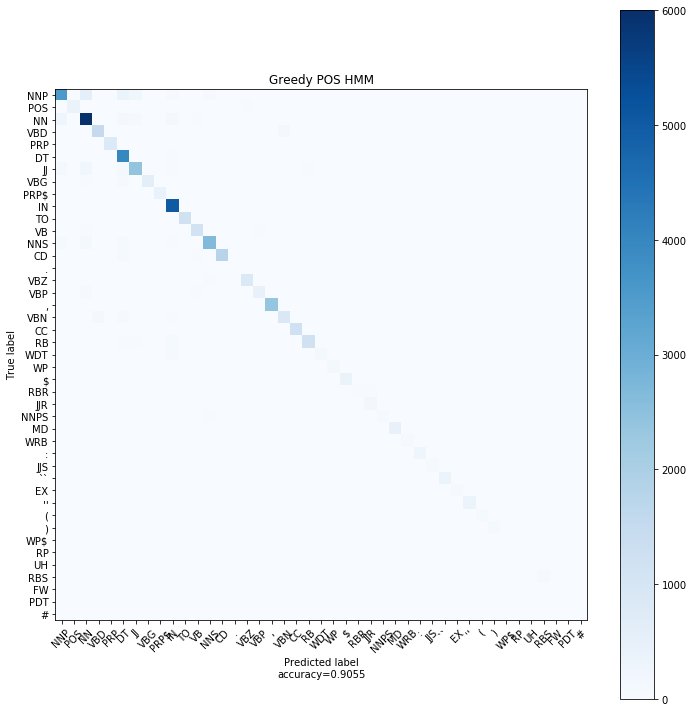

In [20]:
import matplotlib.pyplot as plt
import itertools
title='Greedy POS HMM'
target_names=labels
cmap = plt.get_cmap('Blues')
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
pass
plt.yticks(tick_marks, target_names)
pass
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(accuracy))
plt.show()

### 6.5 Calculate which labels have the most errors percentage wise ###

In [21]:
errors=[]
for a in range(len(labels)):
    # Display errors independently by label, by percentage
    #errors.append([labels[a], sum(cm[:,a])-cm[a,a], sum(cm[:,a])])
    # by percent
    num=(sum(cm[:,a])-cm[a,a])
    den=sum(cm[:,a])
    if den != 0:
        res=float(num)/float(den)    
    else:
        res=0.0
    errors.append([labels[a],res])


### 6.6 Display the labels that have gotten the most errors ###

In [22]:
errors.sort(key=itemgetter(1), reverse=True)
errors[0:5]

[['RP', 0.7894736842105263],
 ['PDT', 0.6],
 ['NNPS', 0.2777777777777778],
 ['RBR', 0.2708333333333333],
 ['DT', 0.1871297242083759]]

# 7.- Viterbi Decoder #

## *Important: Run sections 1-4, we need to initialize those values/variables to continue through this section* ##

### 7.1 Auxiliary Functions ###

##### buildLattice: This function generates a brand new pandas dataframe that will act as a lattice. There will be one of this matrices per sentence#####
After this function, the lattice is return with NaN values, but with all the rows, initialized with the tags (hidden states) as an index

In [23]:
def buildLattice(sequence):
    labels=[]
    [labels.append("W"+str(l)) for l in range(len(sequence))]
    lattice=pd.DataFrame(columns=labels)
    lattice['tags']=tagsList
    lattice=lattice.set_index('tags')
    return lattice

Via this article https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists I found this fast way to flat a list of lists

In [24]:
import functools
import operator
def functools_reduce_iconcat(a):
    return functools.reduce(operator.iconcat, a, [])

##### minList: will return the smallest value from a list #####

In [25]:
def minList(data,tags):
    index=np.argmin(data)
    return data[index], tags[index]

*****************

### 7.3 Main Viterbi decoder function ###

In [26]:
import math
import time
from collections import OrderedDict

# Functino used in a map(lambda) that will
# return the minimum value out of n dictionaries,
# where n = len(tags). We can not make a one ditionary
# because the keys are not unique, they are the back
# pointer, which can lead to the same value several times
def processMin(d,lowest, keyVal,currTag,i):
    key,val=next(iter(d.items()))
    if val < lowest[0]:
        lowest[0]=val
        keyVal[0]=key
        currTag[0]=tagsList[i[0]]
    i[0]=i[0]+1
        
        
# Function that asks, what is the back pointer Tag, and 
# current Tag that has the lowest value
def minInDict(data):
    lowest=[99999999]
    keyVal=['.']
    currTag=['.']
    i=[0]
    for d in data:
        (list(map(lambda x: x(d, 
                              lowest,
                              keyVal,
                              currTag,
                              i),
                  [processMin])))
    return keyVal[0], currTag[0]


# Let's perform back step so we can recreate the best path
def backwards(lattice):
    retTbl=[]
    # First swap the columns so we can go backwards
    reverse_cols = np.flip(lattice.columns.values,axis=0).tolist()
    
    # Now get the minimum value from the last word.
    bestTag, currTag=minInDict(lattice[reverse_cols[0]])
    retTbl.append(currTag)
    #lowest_key,val=next(iter(d.items()))
            
    for w in reverse_cols[1:]:
        v=lattice.loc[bestTag,w]
        retTbl.append(bestTag)
        bestTag,_=next(iter(v.items()))
    #Now let's flip the result because we iterated backwards
    retTbl=np.flip(retTbl,axis=0).tolist()
    return retTbl
    
    
    
def decodeViterbi(seqDf, lattice_tmp, trprob):
    global tagsList
    sequence= seqDf.word.tolist()
    prevTag='.'
    prevEmPr=1.0 # Previous argmax'ed emission probability
    best_score = [0] * len(tagsList)
    seqCntr=0
    tasks=lattice.shape[1] # Get total of iterations to show the progress bar
    for word in lattice_tmp:
        first_pass_scores=[]
        tmp_tbl=[]
        for tag, val in lattice_tmp[word].items():
            score_tag=[]
            # Iterate per node, through all the probabilities for each one of the tags
            #for prev_node in tags:
            for i in range(len(tagsList)):
                prev_node=tagsList[i]
                trprob[tag][prev_node]
                PW_T(W=sequence[seqCntr], T=tag)
                score_tag.append(best_score[i]+(-1*math.log(trprob[tag][prev_node]))+(-1*math.log(PW_T(W=sequence[seqCntr], T=tag))))
            minScore,t_tag=minList(score_tag,tagsList)
            tmp_tbl.append({t_tag:minScore})
            first_pass_scores.append(minScore)
        # Now that we have the minimum log probabilities
        # per word, we will save those results to that same
        # column, so we propagate the probabilities forward

        best_score=first_pass_scores
        lattice_tmp[word]=tmp_tbl
        seqCntr=seqCntr+1

        
    # Back steps
    reverse_cols = np.flip(lattice_tmp.columns.values,axis=0).tolist()
    hyp=[]
    first_col=True
    lowest_key=''
    currTag=''
    tags=lattice_tmp.index.tolist()
    return backwards(lattice_tmp)

# 8.- Perform Evaluation using Test Set #


### 8.1.- Do evaluation and save truth and predictions ###

In [29]:
target=[]
hyp=[]
tasks = len(sentences)
with tqdm_notebook(total=tasks) as pbar:
    start = time.time()
    cnt=0
    for s in sentences:
        target.append(s.pos.tolist())
        lattice=buildLattice(s)
        hyp.append(decodeViterbi(s, lattice, transitionProbs))
        pbar.update(1)
    end = time.time()
    print("Elapsed time = {}".format(end - start))


Elapsed time = 245.00945782661438



### 8.2 Concatenate each setence array into one big array for evaluation ###


In [30]:
hyp=functools_reduce_iconcat(hyp)
target=functools_reduce_iconcat(target)

### 8.3 Calculate Accuracy ###

In [31]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(target, hyp)
print("Accuracy on test set via greedy decoder = {}".format(accuracy))

Accuracy on test set via greedy decoder = 0.9246729218977138


### 8.4 Calculate confusion matrix ###

In [32]:
from sklearn.metrics import confusion_matrix
a=(Counter(test_data.pos).keys())
labels=[*a]
cm=confusion_matrix(target, hyp,labels=labels)

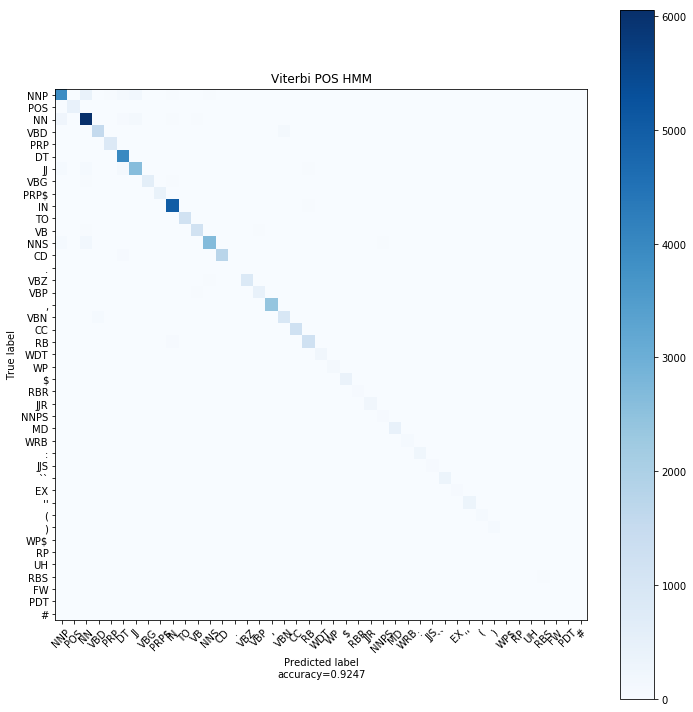

In [33]:
import matplotlib.pyplot as plt
import itertools
title='Viterbi POS HMM'
target_names=labels
cmap = plt.get_cmap('Blues')
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
pass
plt.yticks(tick_marks, target_names)
pass
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(accuracy))
plt.show()

### 8.5 Calculate which labels have the most errors percentage wise ###

In [34]:
errors=[]
for a in range(len(labels)):
    # Display errors independently by label, by percentage
    #errors.append([labels[a], sum(cm[:,a])-cm[a,a], sum(cm[:,a])])
    # by percent
    num=(sum(cm[:,a])-cm[a,a])
    den=sum(cm[:,a])
    if den != 0:
        res=float(num)/float(den)    
    else:
        res=0.0
    errors.append([labels[a],res])



### 8.6 Display the labels that have gotten the most errors ###


In [35]:
errors.sort(key=itemgetter(1), reverse=True)
errors[0:5]

[['.', 1.0],
 ['RP', 0.75],
 ['NNPS', 0.27835051546391754],
 ['PDT', 0.25],
 ['VBN', 0.14089661482159194]]